In [17]:
import datetime, itertools, sys, copy
import matplotlib.pyplot as plt
import pandas as ps
import numpy as np
from subprocess import Popen, PIPE
from multiprocessing import Pool
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import classification_report
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from scipy.cluster.hierarchy import ward, fcluster
import matplotlib.pyplot as plt
from pymystem3 import Mystem
import nltk

In [18]:
data_d1 = ps.read_csv("data/day-1432-cl.csv", sep=';', header=None,
                   index_col=0,names=['id','title','text','cluster','date','publisher'])
data_d2 = ps.read_csv("data/day-1465-cl.csv", sep=';', header=None,
                   index_col=0,names=['id','title','text','cluster','date','publisher'])
print("Число записей за день 1:", len(data_d1))
print("Число записей за день 2:", len(data_d2))

Число записей за день 1: 1425
Число записей за день 2: 1465


In [55]:
data = ps.read_csv("data/120k-utf8.csv", sep=';', header=None,
                   index_col=0,names=['id','title','text','cluster','date','publisher'])
data_d1_ucl = data[data["date"] == data_d1["date"][0]]

## Функции подбора оптимального порога

In [20]:
def do_stem(df):
    mystem = Mystem()
    messages = ["".join(mystem.lemmatize(row["title"] + ". " + row["text"])) for _, row in df.iterrows()]
    nouns_sets = [get_message_nouns(msg, mystem) for msg in messages]
    clusters = [row["cluster"] for _, row in df.iterrows()]
    mystem.close()
    return messages, nouns_sets, clusters

In [21]:
stop_words = set(nltk.corpus.stopwords.words('russian'))

def get_message_nouns(msg, mystem):
    nouns = set()
    words = mystem.analyze(msg)
    for w in words:
        if "analysis" not in w:
            continue
        if w["analysis"] and "S" in w["analysis"][0]["gr"]:
            lex = w["analysis"][0]["lex"]
            if lex and len(lex) > 2 and lex not in stop_words:
                nouns.add(lex)
        elif not w["analysis"] and len(w["text"]) > 2:
            nouns.add(w["text"].lower())
    return nouns

In [22]:
def get_optimal_threshold(data_1d, max_df=0.1, use_nouns=False, use_svd=False, svd_dim=100, base_th=1.0):
    messages, nouns_sets, clusters = do_stem(data_1d)
    
    tfidf_vectorizer = TfidfVectorizer(min_df=2, max_features=10000, max_df=max_df,
        stop_words=nltk.corpus.stopwords.words('russian'))
    tfidf_matrix = tfidf_vectorizer.fit_transform(messages)
    
    if use_svd:
        if type(svd_dim) is float:
            svd_dim = int(tfidf_matrix.shape[1]*svd_dim)
        svd = TruncatedSVD(svd_dim, random_state=42)
        lsa = make_pipeline(svd, Normalizer(copy=False))
        tfidf_matrix = lsa.fit_transform(tfidf_matrix)
    
    dist_matrix = 1 - cosine_similarity(tfidf_matrix)
    linkage_matrix = ward(dist_matrix)
    
    if use_nouns:
        th, res = optimise_threshold(linkage_matrix, clusters, base_th, nouns_sets)
    else:
        th, res = optimise_threshold(linkage_matrix, clusters, base_th)
        
    return th, res

In [23]:
def get_scores_for_interval(linkage_matrix, clusters, t1, t2, ts, noun_sets=None, f_only=True):
    scores = {}
    th = t1
    while th <= t2:
        labels = get_labels(linkage_matrix, len(clusters), th, noun_sets)
        res = marks_to_pairwise(clusters, labels)
        if f_only:
            scores[th] = get_prec_recall_f(res, 1)[2]
        else:
            scores[th] = get_prec_recall_f(res, 1)
        th += ts
    return scores

In [24]:
def optimise_threshold(linkage_matrix, clusters, base_th = 1.0, noun_sets=None):
    scores = get_scores_for_interval(linkage_matrix, clusters,
                                    base_th, base_th+1.0, 0.1, noun_sets)
    th_m = max((f, th) for th, f in scores.items())[1]
    scores.update(get_scores_for_interval(linkage_matrix, clusters,
                                          th_m-0.1, th_m+0.1, 0.01,
                                          noun_sets))
    th_m = max((f, th) for th, f in scores.items())[1]
    labels = get_labels(linkage_matrix, len(clusters), th_m, noun_sets)
    res = marks_to_pairwise(clusters, labels)
    return th_m, res

In [25]:
def get_labels(linkage_matrix, n_samples, cutoff, noun_sets=None):
    clusters = {i: [i] for i in range(n_samples)}
    for i, row in enumerate(linkage_matrix):
        c1, c2, dist, cls_size = row
        c1, c2 = int(c1), int(c2)
        if cutoff and dist > cutoff:
            break
        if not clusters[c1] or not clusters[c2]:
            clusters[n_samples+i] = []
            continue
        
        if noun_sets:
            all_indexes = clusters[c1] + clusters[c2]
            all_nouns = [noun_sets[i] for i in all_indexes]
            common_nouns = all_nouns[0]
            for nouns in all_nouns[1:]:
                common_nouns &= nouns
            if not common_nouns:
                clusters[n_samples+i] = []
                continue
        
        clusters[n_samples+i] = clusters[c1] + clusters[c2]
        del clusters[c1]
        del clusters[c2]
    
    labels = [None] * n_samples
    for cls_num, objects in clusters.items():
        for o in objects:
            labels[o] = cls_num
    return labels

In [26]:
def marks_to_pairwise(y_cls, p_cls, ids=None):
    assert len(y_cls) == len(p_cls)
    res = {"ids": [], "y": [], "p": []}
    for i1, i2 in itertools.combinations(range(len(y_cls)), 2):
        if ids is None:
            res["ids"].append(sorted((i1, i2)))
        else:
            res["ids"].append(sorted((ids[i1], ids[i2])))
        res["y"].append(bool(y_cls[i1] == y_cls[i2]))
        res["p"].append(bool(p_cls[i1] == p_cls[i2]))
    return ps.DataFrame(res, index=None)

In [27]:
def get_prec_recall_f(res, cls):
    pred = res[res["p"] == cls]
    if len(pred) == 0:
        return 0, 0, 0
    prec = len(pred[pred["y"] == cls]) / len(pred)
    act = res[res["y"] == cls]
    if len(act) == 0:
        return 0, 0, 0
    rec = len(act[act["p"] == cls]) / len(act)
    
    if prec == 0 or rec == 0:
        return prec, rec, 0
    return prec, rec, 2/(1/prec + 1/rec)

In [28]:
def cross_class_report(res):
    classes = res["y"].unique()
    table = ps.DataFrame(index=classes, columns=classes)
    for true_cls in classes:
        tmp = res[res["y"] == true_cls]
        for pred_cls in classes:
            table[pred_cls][true_cls] = len(tmp[tmp["p"] == pred_cls])
    return table

## Подбор порога для первого дня
Без сингулярного разоложения и правила общих существительных:

In [94]:
th, res = get_optimal_threshold(data_d1)
print("Порог:", th)
print(classification_report(res["y"], res["p"], digits=4))
print(cross_class_report(res), "\n\n")

Порог: 1.4400000000000004
             precision    recall  f1-score   support

      False     0.9995    0.9999    0.9997   1013331
       True     0.8373    0.6044    0.7021      1269

avg / total     0.9993    0.9994    0.9993   1014600

      True     False
True    767      502
False   149  1013182 




С сингулярным разложением, но без правила общих существительных:

In [93]:
th, res = get_optimal_threshold(data_d1, use_svd=True, svd_dim=200, base_th=1.8)
print("Порог:", th)
print(classification_report(res["y"], res["p"], digits=4))
print(cross_class_report(res), "\n\n")

Порог: 2.5799999999999987
             precision    recall  f1-score   support

      False     0.9997    0.9998    0.9997   1013331
       True     0.8189    0.7660    0.7915      1269

avg / total     0.9995    0.9995    0.9995   1014600

      True     False
True    972      297
False   215  1013116 




С правилом общих существительных, но без сингулярного разложения:

In [24]:
th, res = get_optimal_threshold(data_d1, use_nouns=True)
print("Порог:", th)
print(classification_report(res["y"], res["p"], digits=4))
print(cross_class_report(res), "\n\n")

Порог: 1.8900000000000008
             precision    recall  f1-score   support

      False       1.00      1.00      1.00   1014749
       True       0.61      0.81      0.69      1276

avg / total       1.00      1.00      1.00   1016025

      True     False
True   1032      244
False   672  1014077 




С сингулярным разложением и правилом общих существительных:

In [95]:
th, res = get_optimal_threshold(data_d1, use_svd=True, use_nouns=True, svd_dim=225, base_th=2.0)
print("Порог:", th)
print(classification_report(res["y"], res["p"], digits=4))
print(cross_class_report(res), "\n\n")

Порог: 2.5899999999999985
             precision    recall  f1-score   support

      False     0.9997    0.9998    0.9997   1013331
       True     0.8023    0.7801    0.7911      1269

avg / total     0.9995    0.9995    0.9995   1014600

      True     False
True    990      279
False   244  1013087 




## Подбор порога для второго дня

In [32]:
th, res = get_optimal_threshold(data_d2, use_svd=True, svd_dim=225, base_th=1.8)
print("Порог:", th)
print(classification_report(res["y"], res["p"], digits=4))
print(cross_class_report(res), "\n\n")

Порог: 2.2699999999999965
             precision    recall  f1-score   support

      False     0.9997    0.9998    0.9998   1071064
       True     0.8505    0.7698    0.8081      1316

avg / total     0.9995    0.9996    0.9995   1072380

         False True 
False  1070886   178
True       303  1013 




## Подбор порога для неочищенных данных

In [29]:
def relabel_data(data_t):
    for i, ind in enumerate(data_t.index):
        if data_t.loc[ind]["cluster"] == "-":
            data_t.loc[ind]["cluster"] = "NONE_" + str(i)
    return data_t

In [52]:
data_t = relabel_data(data_d1_ucl)
th, res = get_optimal_threshold(data_t, use_svd=True, svd_dim=225, base_th=1.5)
print("Порог:", th)
print(classification_report(res["y"], res["p"], digits=4))
print(cross_class_report(res), "\n\n")

Порог: 2.02
             precision    recall  f1-score   support

      False     0.9998    0.9995    0.9997   1024181
       True     0.3412    0.6289    0.4424       415

avg / total     0.9996    0.9994    0.9995   1024596

         False True 
False  1023677   504
True       154   261 




## Лучшие результаты

In [30]:
def get_clusters_labels(data_1d, th, max_df=0.1, use_nouns=False, use_svd=False, svd_dim=100):
    messages, noun_sets, clusters = do_stem(data_1d)
    tfidf_vectorizer = TfidfVectorizer(min_df=2, max_features=10000, max_df=max_df,
        stop_words=nltk.corpus.stopwords.words('russian'))
    tfidf_matrix = tfidf_vectorizer.fit_transform(messages)
    
    if use_svd:
        svd = TruncatedSVD(svd_dim, random_state=42)
        lsa = make_pipeline(svd, Normalizer(copy=False))
        tfidf_matrix = lsa.fit_transform(tfidf_matrix)
        print("SVD explained variance:", np.sum(svd.explained_variance_ratio_), "\n")
    
    dist_matrix = 1 - cosine_similarity(tfidf_matrix)
    linkage_matrix = ward(dist_matrix)
    
    if use_nouns:
        labels = get_labels(linkage_matrix, len(clusters), th, noun_sets)
    else:
        labels = get_labels(linkage_matrix, len(clusters), th)
    
    return clusters, labels

In [31]:
def print_clusterization_results(data_1d, th, max_df=0.1, use_nouns=False, use_svd=False, svd_dim=100):
    clusters, labels = get_clusters_labels(data_1d, th, max_df, use_nouns, use_svd, svd_dim)
    res = marks_to_pairwise(clusters, labels, data_1d.index)
    print("Pairwise results:\n", classification_report(res["y"], res["p"], digits=4))
    print("Predicted vs Real:\n", cross_class_report(res), "\n")

In [102]:
print_clusterization_results(data_d1, 2.55, use_svd=True, svd_dim=225)

SVD explained variance: 0.45178394641 

Pairwise results:
              precision    recall  f1-score   support

      False     0.9997    0.9998    0.9997   1013331
       True     0.8047    0.7888    0.7967      1269

avg / total     0.9995    0.9995    0.9995   1014600

Predicted vs Real:
       True     False
True   1001      268
False   243  1013088 



In [34]:
print_clusterization_results(data_d2, 2.27, use_svd=True, svd_dim=225)

SVD explained variance: 0.460288471827 

Pairwise results:
              precision    recall  f1-score   support

      False     0.9997    0.9998    0.9998   1071064
       True     0.8505    0.7698    0.8081      1316

avg / total     0.9995    0.9996    0.9995   1072380

Predicted vs Real:
          False True 
False  1070886   178
True       303  1013 



In [35]:
print_clusterization_results(data_d2, 2.55, use_svd=True, svd_dim=225)

SVD explained variance: 0.460288471827 

Pairwise results:
              precision    recall  f1-score   support

      False     0.9998    0.9997    0.9997   1071064
       True     0.7514    0.8131    0.7810      1316

avg / total     0.9995    0.9994    0.9995   1072380

Predicted vs Real:
          False True 
False  1070710   354
True       246  1070 



In [18]:
print_clusterization_results(data_d1, 2.27, use_svd=True, svd_dim=225)

SVD explained variance: 0.45178394641 

Pairwise results:
              precision    recall  f1-score   support

      False     0.9995    0.9999    0.9997   1013331
       True     0.8646    0.6391    0.7349      1269

avg / total     0.9994    0.9994    0.9994   1014600

Predicted vs Real:
       True     False
True    811      458
False   127  1013204 



In [22]:
clusters, labels = get_clusters_labels(data_d1, 2.27, max_df=0.1, use_nouns=False, use_svd=True, svd_dim=225)
res_d1 = marks_to_pairwise(clusters, labels, data_d1.index)
clusters, labels = get_clusters_labels(data_d2, 2.55, max_df=0.1, use_nouns=False, use_svd=True, svd_dim=225)
res_d2 = marks_to_pairwise(clusters, labels, data_d2.index)
res = ps.concat([res_d1, res_d2])
print("Pairwise results:\n", classification_report(res["y"], res["p"], digits=4))
print("Predicted vs Real:\n", cross_class_report(res), "\n")

SVD explained variance: 0.45178394641 

SVD explained variance: 0.460288471827 

Pairwise results:
              precision    recall  f1-score   support

      False     0.9997    0.9998    0.9997   2084395
       True     0.7964    0.7277    0.7605      2585

avg / total     0.9994    0.9994    0.9994   2086980

Predicted vs Real:
       True     False
True   1881      704
False   481  2083914 



## Двусторонний отчёт об ошибках кластеризации

In [32]:
def export_clusterization_report(data_1d, th, filename, max_df=0.1, use_nouns=False, use_svd=False, svd_dim=100):
    clusters, labels = get_clusters_labels(data_1d, th, max_df, use_nouns, use_svd, svd_dim)
    res = marks_to_pairwise(clusters, labels, data_1d.index)
    print("Сообщений:", len(data_1d))
    print(classification_report(res["y"], res["p"], digits=4))
    print(cross_class_report(res), "\n\n")
    
    texts = [row["title"] + ". " + row["text"] for _, row in data_1d.iterrows()]
    results = ps.DataFrame({"id": data_1d.index, "message": texts,
                            "y": clusters, "p": labels}, index=None)
    
    # Отчёт об ложно объединённых сообщениях:
    with open(filename + "-fpos.txt", "w") as f:
        for _, df in results.groupby("p"):
            if len(df["y"].unique()) == 1:
                continue
            df = df.sort_values("y")
            cluster_letter = {c: l for c, l in zip(sorted(df["y"].unique()), "абвгдежзиклмно")}
            f.write("Участвующие кластеры:\n")
            for c, l in sorted(cluster_letter.items(), key=lambda x: x[0]):
                f.write("  {}) '{}'\n".format(l, c))
            f.write("Сообщения:\n")
            for _, row in df.iterrows():
                f.write("  ({}) {}\n".format(cluster_letter[row["y"]], row["message"]))
            f.write("\n")
    
    # Отчёт о ложно не объединённых сообщениях:
    with open(filename + "-fneg.txt", "w") as f:
        for cluster, df in results.groupby("y"):
            if len(df["p"].unique()) == 1:
                continue
            df = df.sort_values("p")
            f.write("Кластер: {}\n".format(cluster))
            pred_letter = {c: l for c, l in zip(sorted(df["p"].unique()), "абвгдежзиклмно")}
            f.write("Сообщения:\n")
            for _, row in df.iterrows():
                f.write("  ({}) ${}$ {}\n".format(pred_letter[row["p"]], row["id"], row["message"]))
            f.write("\n")

In [85]:
export_clusterization_report(data_d1, 2.61, "reports-full/report-day1431", use_svd=True, svd_dim=225)

Explained variance: 0.451887784071
Сообщений: 1425
             precision    recall  f1-score   support

      False       1.00      1.00      1.00   1013254
       True       0.78      0.76      0.77      1346

avg / total       1.00      1.00      1.00   1014600

      True     False
True   1017      329
False   285  1012969 




In [30]:
export_clusterization_report(data_d2, 2.25, "reports-full/report-day1465", use_svd=True, svd_dim=225)

SVD explained variance: 0.460265584341 

Сообщений: 1465
             precision    recall  f1-score   support

      False     0.9995    0.9999    0.9997   1070854
       True     0.8681    0.6769    0.7607      1526

avg / total     0.9994    0.9994    0.9994   1072380

         False True 
False  1070697   157
True       493  1033 




# Построение графиков по дням

In [35]:
data_days = [relabel_data(df.copy()) for day, df in data.groupby("date") if 300 < len(df) < 4000]
print("Число дней:", len(data_days))
print(sorted(len(d) for d in data_days))

Число дней: 22
[315, 336, 437, 477, 506, 547, 568, 585, 627, 940, 1120, 1127, 1137, 1145, 1158, 1161, 1164, 1183, 1191, 1212, 1432, 1465]


In [54]:
print("Размеры матриц TD*IDF:")
for data_1d in sorted(data_days, key=lambda x: len(x)):
    messages, nouns_sets, clusters = do_stem(data_1d)
    
    max_df = 50/len(data_1d)
    if max_df < 0.1:
        max_df = 0.1
    
    tfidf_vectorizer = TfidfVectorizer(min_df=2, max_features=10000, max_df=max_df,
        stop_words=nltk.corpus.stopwords.words('russian'))
    tfidf_matrix = tfidf_vectorizer.fit_transform(messages)
    print("{}: {}".format(len(data_1d), tfidf_matrix.shape))

Размеры матриц TD*IDF:
315: (315, 1088)
336: (336, 1197)
437: (437, 1508)
477: (477, 1573)
506: (506, 1749)
547: (547, 1701)
568: (568, 1819)
585: (585, 1781)
627: (627, 1940)
940: (940, 2908)
1120: (1120, 3331)
1127: (1127, 3381)
1137: (1137, 3383)
1145: (1145, 3353)
1158: (1158, 3415)
1161: (1161, 3336)
1164: (1164, 3443)
1183: (1183, 3416)
1191: (1191, 3438)
1212: (1212, 3539)
1432: (1432, 3945)
1465: (1465, 3944)


In [33]:
def get_clusters_linkage(data_1d):
    messages, nouns_sets, clusters = do_stem(data_1d)
    
    max_df = 50/len(data_1d)
    if max_df < 0.1:
        max_df = 0.1
    
    tfidf_vectorizer = TfidfVectorizer(min_df=2, max_features=10000, max_df=max_df,
        stop_words=nltk.corpus.stopwords.words('russian'))
    tfidf_matrix = tfidf_vectorizer.fit_transform(messages)

    svd = TruncatedSVD(int(tfidf_matrix.shape[1]*0.05625), random_state=42)
    lsa = make_pipeline(svd, Normalizer(copy=False))
    tfidf_matrix = lsa.fit_transform(tfidf_matrix)
    
    print("({}) expalained variance: {}".format(len(data_1d), np.sum(svd.explained_variance_ratio_)))
    
    dist_matrix = 1 - cosine_similarity(tfidf_matrix)
    linkage_matrix = ward(dist_matrix)
    
    return clusters, linkage_matrix

In [36]:
all_scores = {}

for data_1d in data_days:
    clusters, linkage_matrix = get_clusters_linkage(data_1d)
    date = data_1d["date"][0]
    all_scores[date] = get_scores_for_interval(linkage_matrix, clusters, 0.5, 3.0, 0.1, f_only=False)

(1158) expalained variance: 0.40894153051798965
(1161) expalained variance: 0.41268767528431727
(1191) expalained variance: 0.40677025192215555
(1432) expalained variance: 0.4456897294331721
(1127) expalained variance: 0.4020680860880707
(1145) expalained variance: 0.4362889865651167
(1164) expalained variance: 0.4016475780045188
(1212) expalained variance: 0.41480327745360634
(1137) expalained variance: 0.40692039716933437
(940) expalained variance: 0.41265223058837186
(1183) expalained variance: 0.42138422238010825
(1465) expalained variance: 0.45465082617290653
(1120) expalained variance: 0.40033430030236916
(506) expalained variance: 0.43162250380953915
(336) expalained variance: 0.4324440598245818
(437) expalained variance: 0.4211198770228891
(315) expalained variance: 0.4488632404206304
(627) expalained variance: 0.39408544638879817
(585) expalained variance: 0.38405009429411613
(568) expalained variance: 0.3933791136900683
(547) expalained variance: 0.38986627738421586
(477) exp

In [74]:
%matplotlib inline
def plot_scores(scores, date, n_sam=None):
    if n_sam is None:
        n_sam = len(data[data["date"] == date])
    
    th_vals = [(th, prec, rec, f) for th, (prec, rec, f) in scores.items()]
    th = [v[0] for v in th_vals]
    prec_rec_f = [[v[i] for v in th_vals] for i in range(1,4)]
    
    plt.figure(figsize=(10,9))
    for color, val, name in zip("rgb", prec_rec_f, ["Точность", "Полнота", "F-мера"]):
        plt.scatter(th, val, c=color, label=name, s=75)
    leg = plt.legend()
    plt.title('Date: {} ({} messages)'.format(date, n_sam))
    
    ax = plt.axes()
    for item in ([ax.title, leg.get_title(), ax.xaxis.label, ax.yaxis.label] + 
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(16)

/usr/lib/python3/dist-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


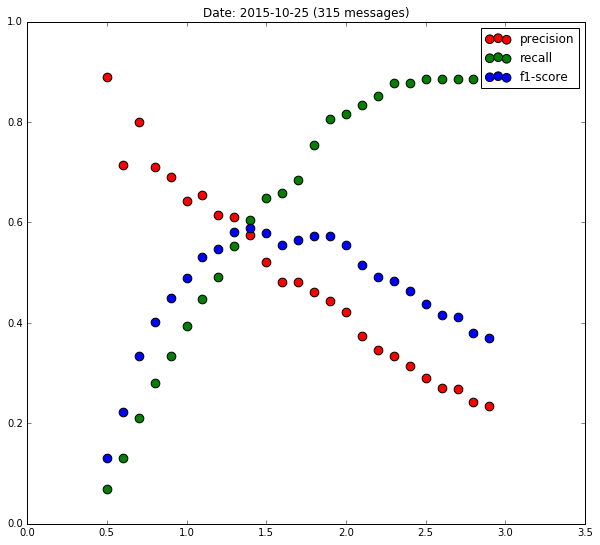

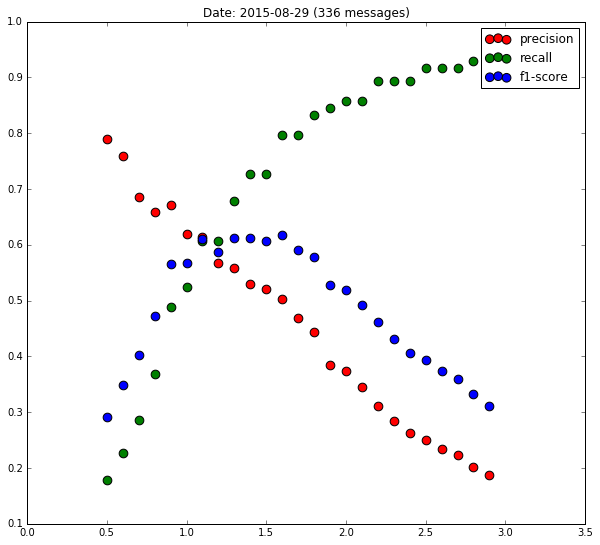

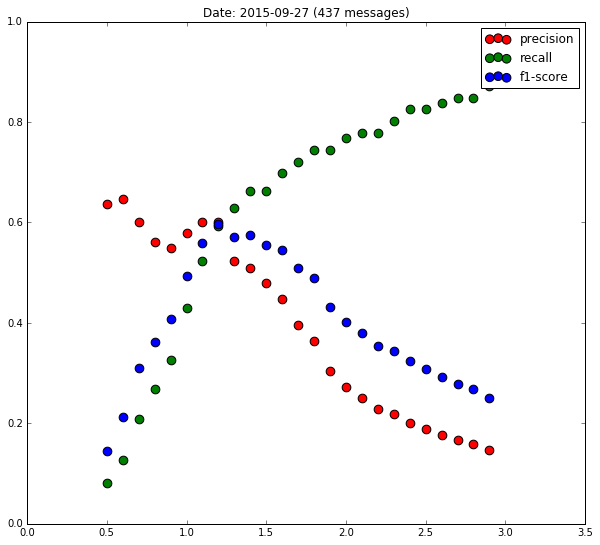

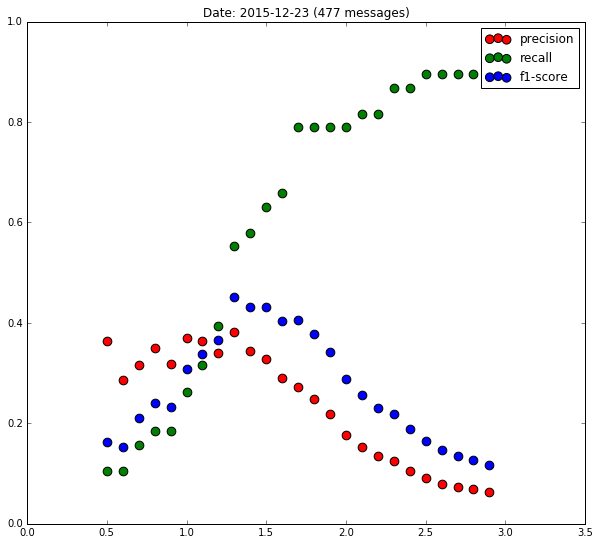

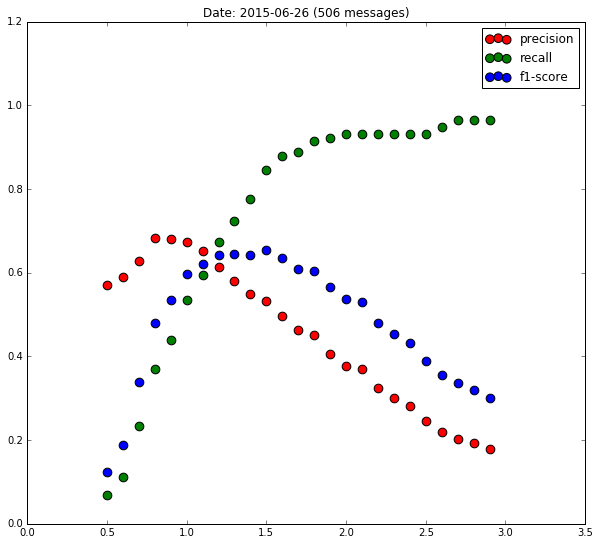

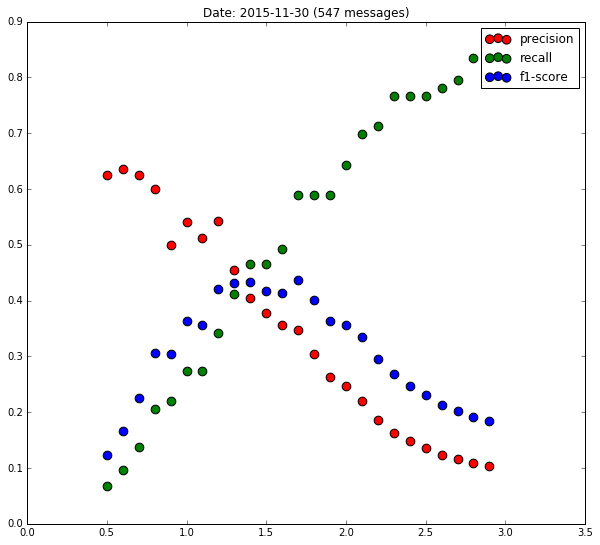

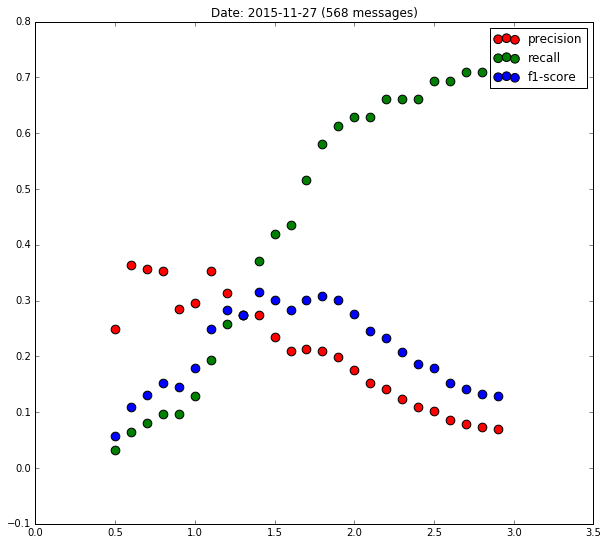

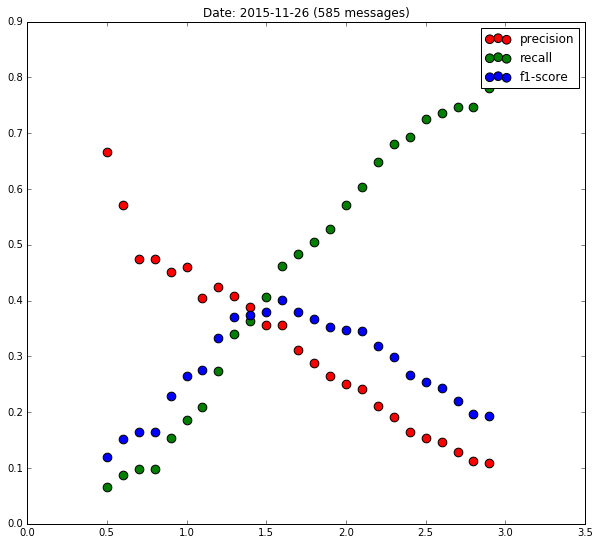

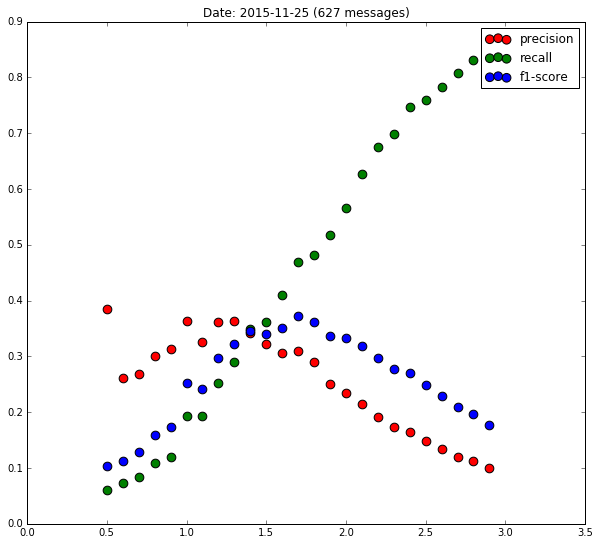

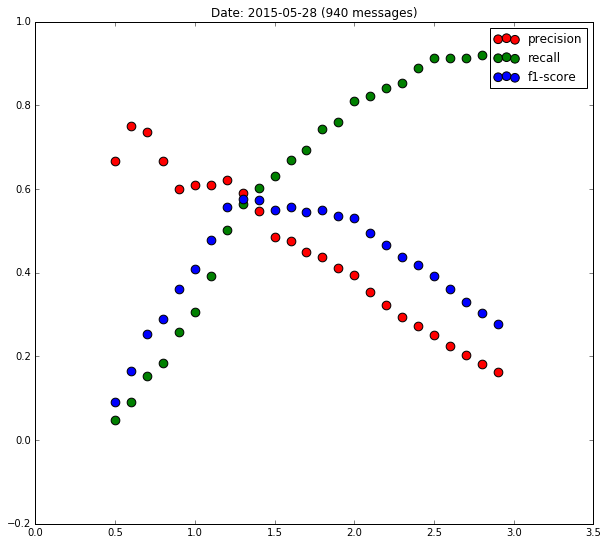

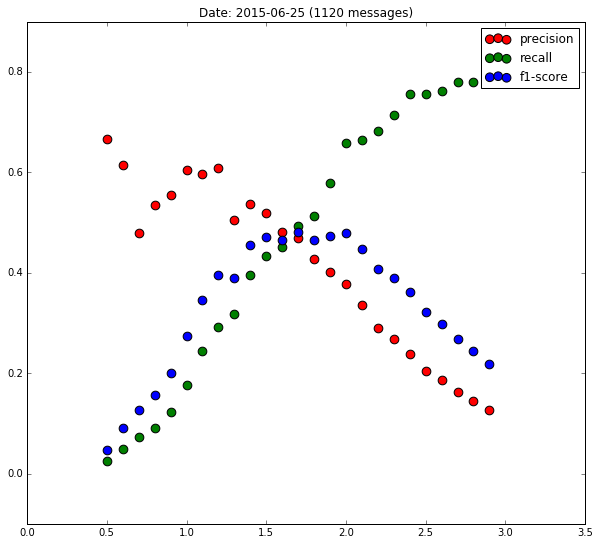

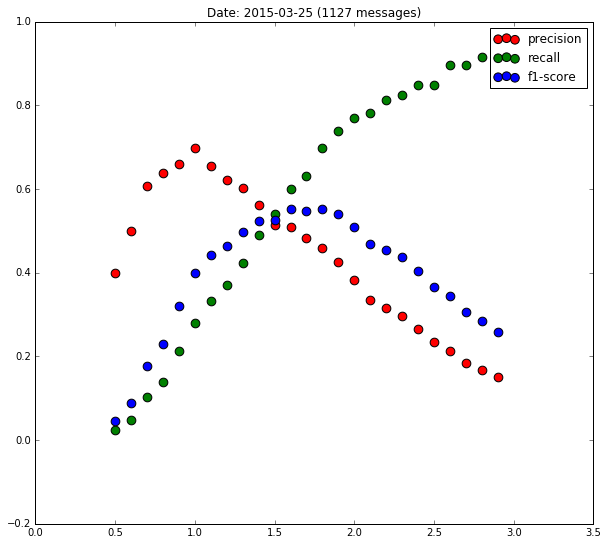

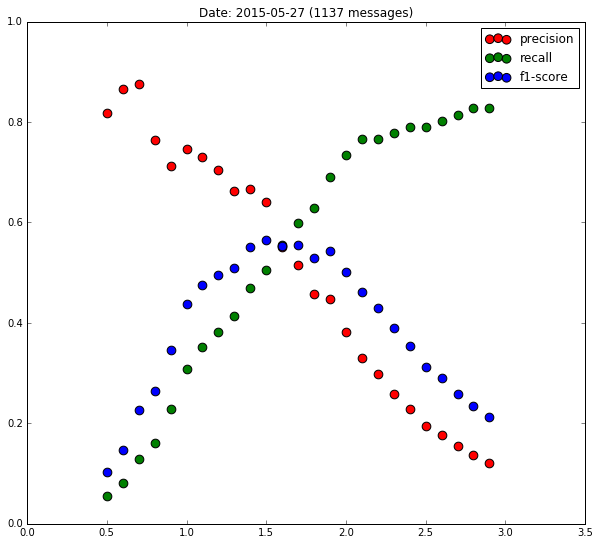

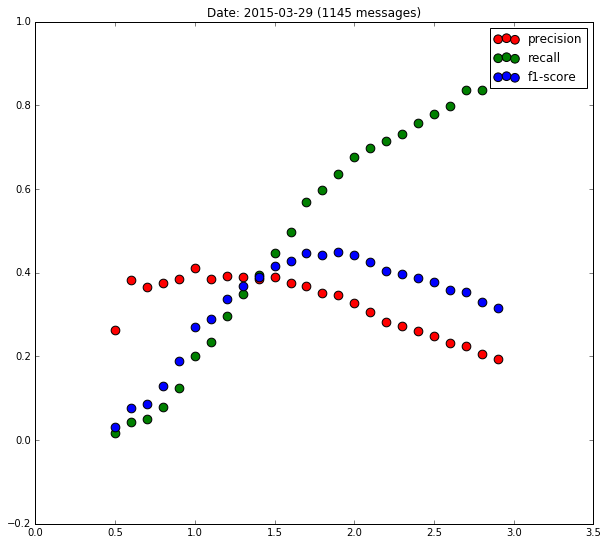

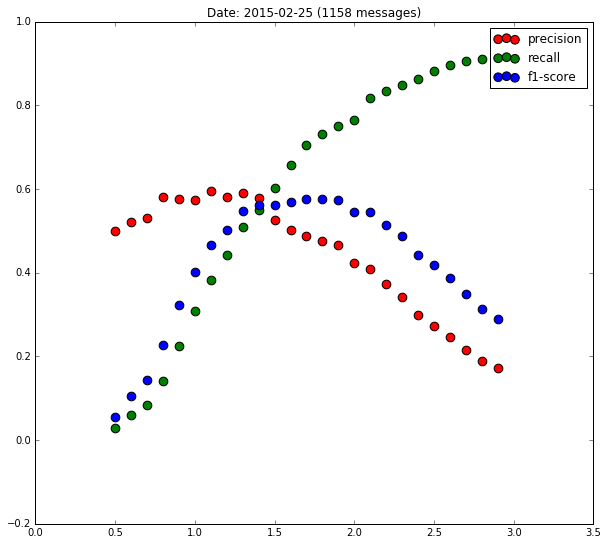

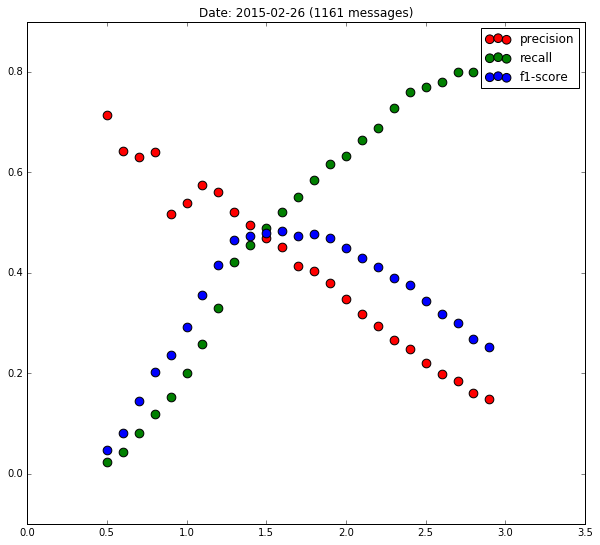

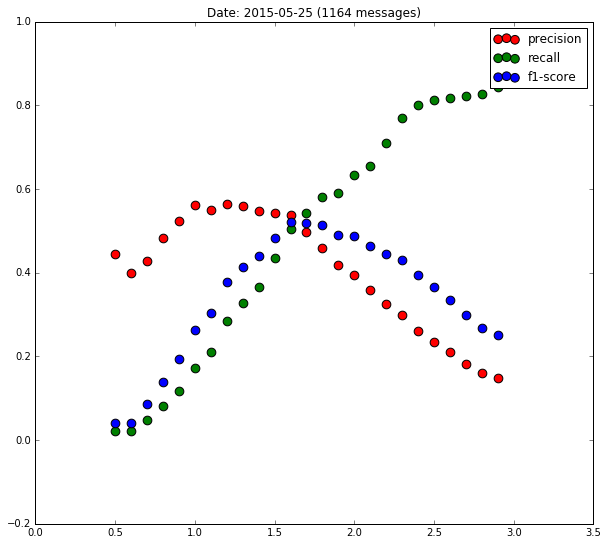

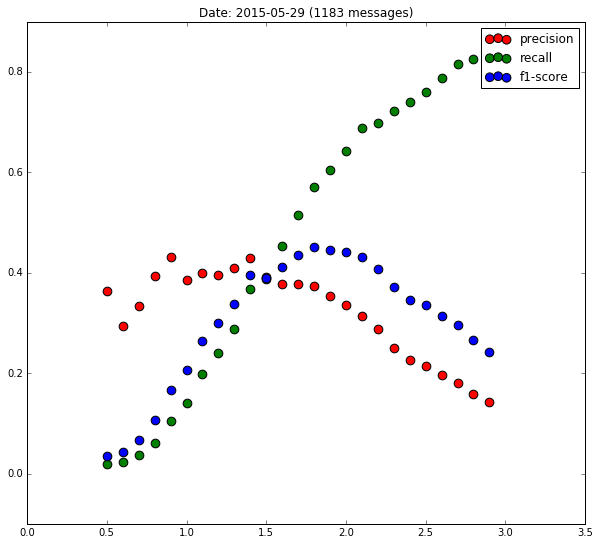

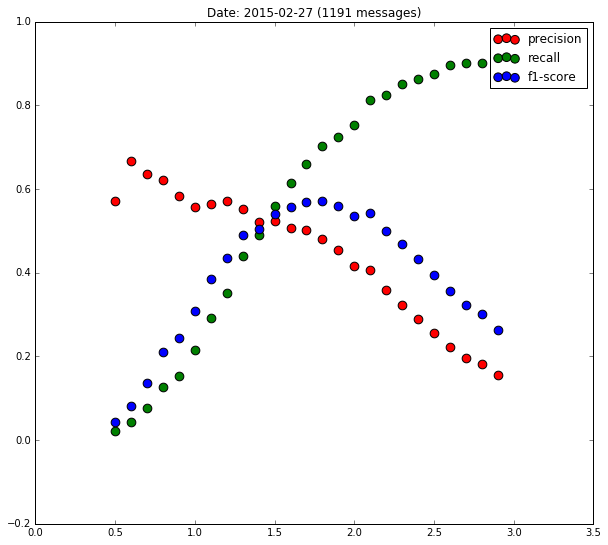

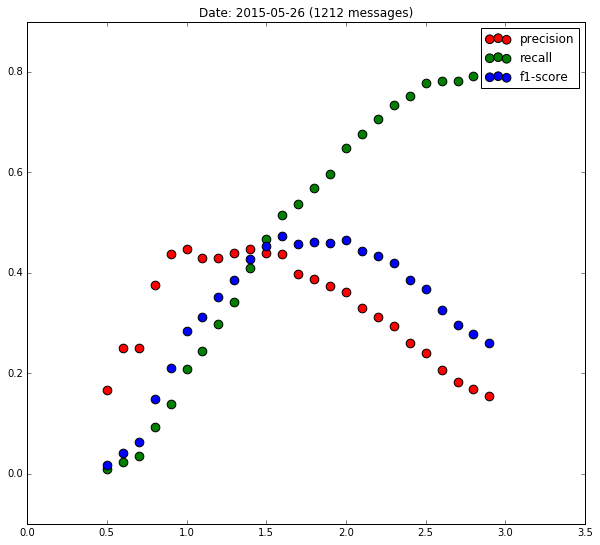

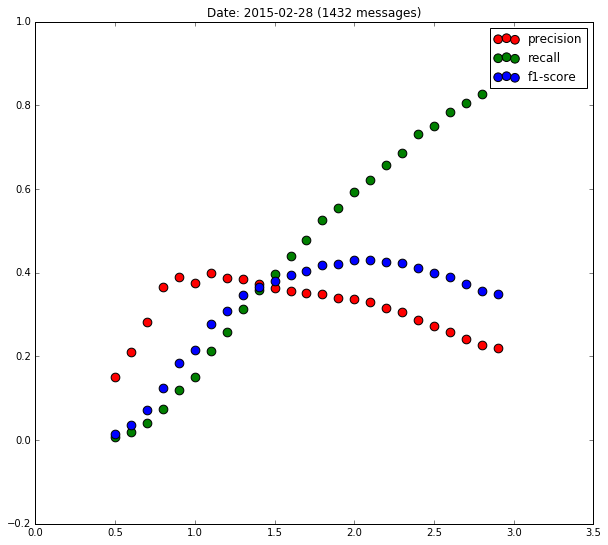

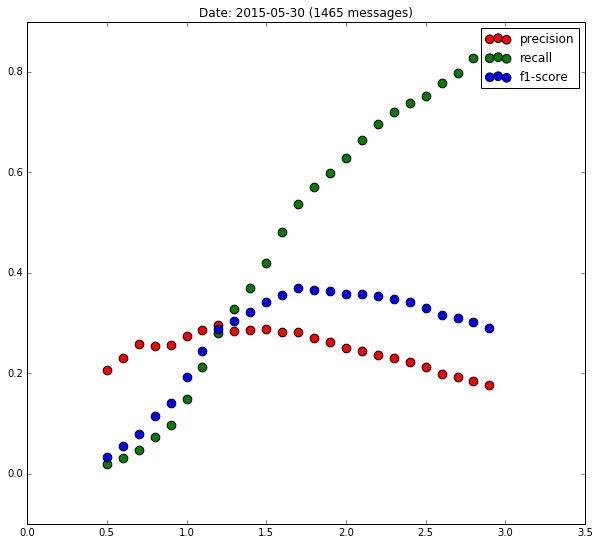

In [56]:
for date, scores in sorted(all_scores.items(), key=lambda x: len(data[data["date"] == x[0]])):
    plot_scores(scores, date)

In [44]:
d2_scores = {}

for data_1d in [data_d1, data_d2]:
    clusters, linkage_matrix = get_clusters_linkage(data_1d)
    date = data_1d["date"][0]
    d2_scores[date] = get_scores_for_interval(linkage_matrix, clusters, 0.5, 5.0, 0.1, f_only=False)

(1425) expalained variance: 0.44689456114569737
(1465) expalained variance: 0.45633846822828084


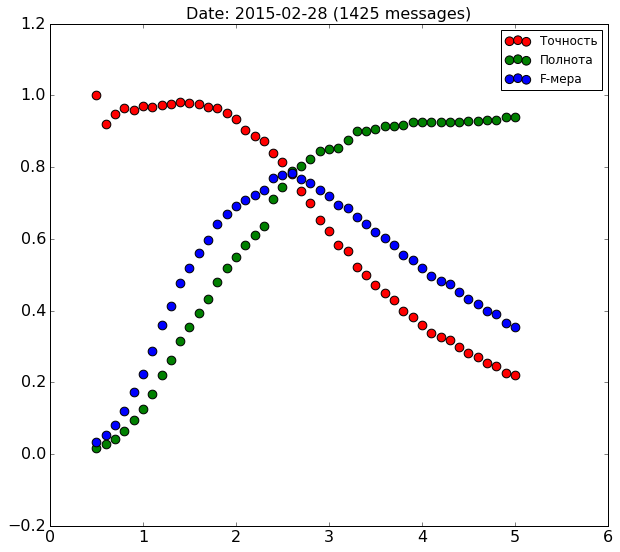

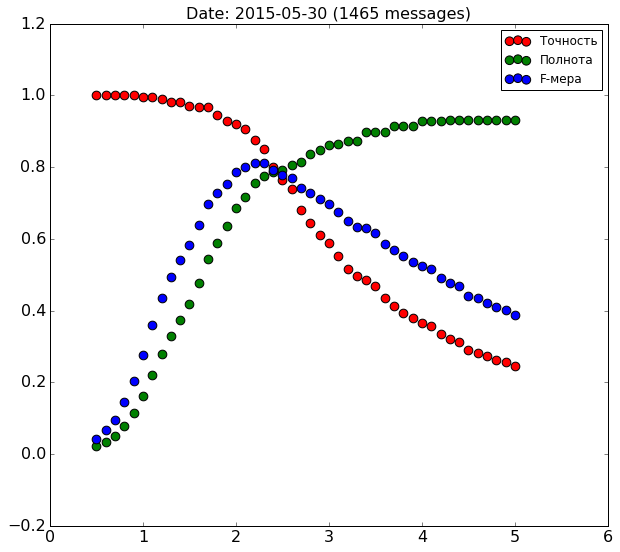

In [75]:
date_scores = sorted(d2_scores.items(), key=lambda x: len(data[data["date"] == x[0]]))
for (date, scores), data_t in zip(date_scores, [data_d1, data_d2]):
    plot_scores(scores, date, len(data_t))

## Уточнение лучших пороговых значений

In [37]:
points_n = []
points_th = []
for data_1d in data_days:
    date = data_1d["date"][0]
    th = max(all_scores[date].items(), key=lambda x: x[1][2])[0]
    
    max_df = 50/len(data_1d)
    if max_df < 0.1:
        max_df = 0.1
    
    th_m = get_optimal_threshold(data_1d, use_svd=True, svd_dim=0.05625, base_th=th-0.5, max_df=max_df)[0]
    
    points_n.append(len(data_1d))
    points_th.append(th_m)

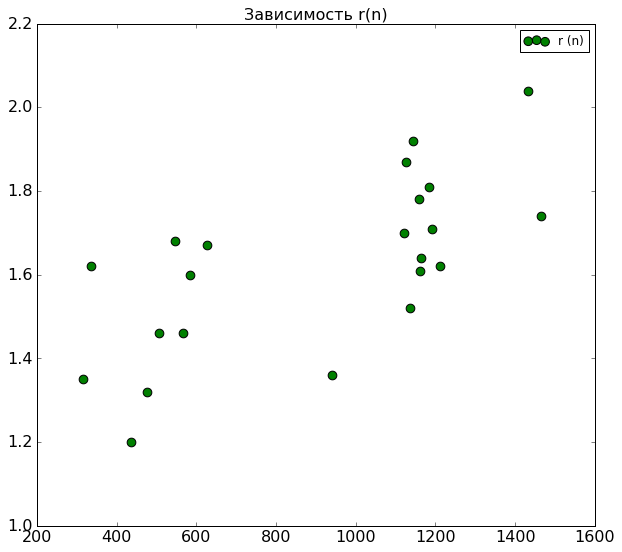

In [78]:
plt.figure(figsize=(10,9))
plt.scatter(points_n, points_th, c='g', label="r (n)", s=75)
leg = plt.legend()
plt.title('Зависимость r(n)'.format(date, len(data[data["date"] == date])))

ax = plt.axes()
for item in ([ax.title, leg.get_title(), ax.xaxis.label, ax.yaxis.label] + 
              ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(16)

In [39]:
date_tfidf_shape = {}
for data_1d in data_days:
    date = data_1d["date"][0]
    messages, nouns_sets, clusters = do_stem(data_1d)
    
    max_df = 50/len(data_1d)
    if max_df < 0.1:
        max_df = 0.1
    
    tfidf_vectorizer = TfidfVectorizer(min_df=2, max_features=10000, max_df=max_df,
        stop_words=nltk.corpus.stopwords.words('russian'))
    tfidf_matrix = tfidf_vectorizer.fit_transform(messages)
    
    date_tfidf_shape[date] = tfidf_matrix.shape

In [40]:
points_sh = list(points_n)
for date, shape in date_tfidf_shape.items():
    n = shape[0]
    i = points_n.index(n)
    points_sh[i] = shape[1]

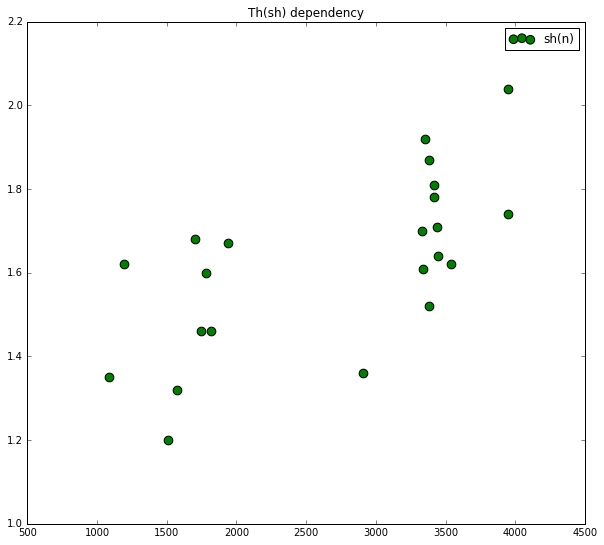

In [41]:
plt.figure(figsize=(10,9))
plt.scatter(points_sh, points_th, c='g', label="sh(n)", s=75)
plt.legend()
plt.title('Th(sh) dependency'.format(date, len(data[data["date"] == date])))